In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Persistent Resource Getting Started (CLI)

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/persistent_resource/00_persistent_resource_getting_started_cli.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/persistent_resource/00_persistent_resource_getting_started_cli.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/persistent_resource/00_persistent_resource_getting_started_cli.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview

A Vertex AI persistent resource is a long-running cluster you can use to submit multiple Vertex AI Training jobs. You can use a persistent resource to ensure compute resource availability and to reduce the job startup time that's otherwise needed to provision compute resources.

Learn more about [Vertex AI Persistent Resources](https://cloud.google.com/vertex-ai/docs/training/persistent-resource-overview).

### Objective

In this tutorial, you learn how to create a persistent resouce and use the persistent resource as a target for submitting a custom training job. You'll also see how the cluster can auto-expand to pull in additional resources. The Google Cloud CLI (`gcloud`) will be used to manage resources.

This tutorial uses the following Google Cloud ML services and resources:

- Cloud Build
- Vertex AI Persistent Resource
- Vertex AI Training


The steps performed include:

- Create a persistent resource with autoscaling
- Build and push the custom training job container image
- Create a custom training job on the persistent resource
- Test autoscaling

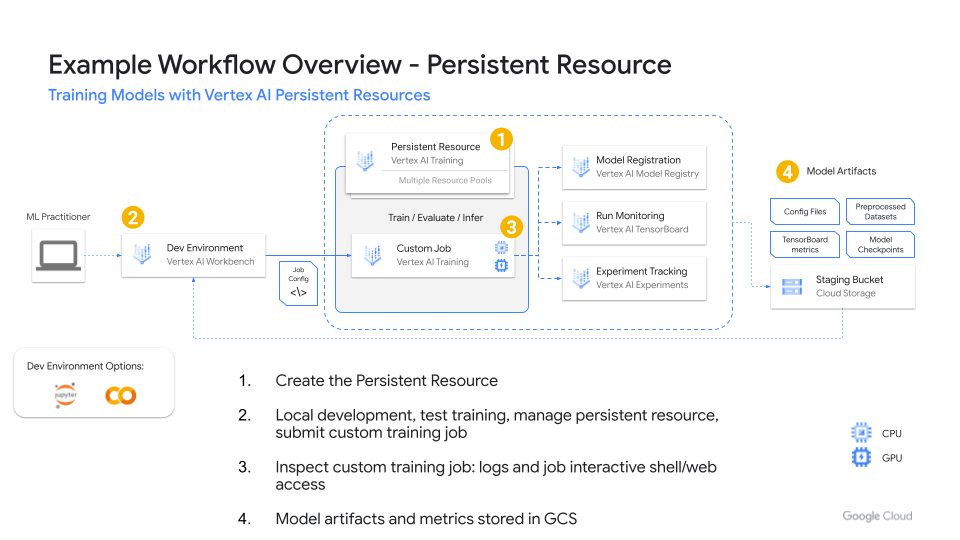

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Build
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
[Cloud Build pricing](https://cloud.google.com/build/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
import sys

# Check if running on Colab to install the packages, then restart the kernel
if "google.colab" in sys.modules:
    !pip3 install --upgrade google-cloud-aiplatform

    # Automatically restart kernel after installs so that your environment can access the new packages
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
else:
    # Install the packages
    !pip3 install --upgrade --quiet google-cloud-aiplatform

In [ ]:
# Ensure your gcloud is 438.0 or later, and it includes the `beta` component
!gcloud --version

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI, Arifact Registry and Cloud Build APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,cloudbuild.googleapis.com,artifactregistry.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
!gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# !gcloud auth login

**3. Colab:**

In [ ]:
import sys

if "google.colab" in sys.modules:
    IS_COLAB = True

    from google.colab import auth

    auth.authenticate_user()
else:
    IS_COLAB = False

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://{PROJECT_ID}-persistent-resource"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
!gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [ ]:
import os
import sys

### Training code container definition

In [ ]:
# Clone sample code repo locally
!git clone https://github.com/GoogleCloudPlatform/vertex-ai-samples.git

In [ ]:
# Training code container def
CONTAINER_DIR = "vertex-ai-samples/notebooks/community/persistent_resource/training_code/mpg_container"

Verify the location where the training code exists

In [ ]:
# Print the location where the training code exists, will be used to create the artifact registry container
print(f"Local container directory with training code: {CONTAINER_DIR}")
print("Check whether the container directory exists:", os.path.exists(CONTAINER_DIR))

In [ ]:
# Repo to create / use for running training job
PRIVATE_REPO = "mpg-training"
TRAIN_IMAGE = (
    f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PRIVATE_REPO}/tf-mpg-training:latest"
)
print("Private Repo:", PRIVATE_REPO)
print("Training Container Image:", TRAIN_IMAGE)

### Persistent Resource definition

In [ ]:
# You may first check the general help info of the command usage.
# !gcloud beta ai persistent-resources create --help

In [ ]:
# ----------- Name your Persistent Resource -----------#
PERSISTENT_RESOURCE_ID = "preview-pr-autoscaling-gcloud-1"  # @param {type:"string"}

### Resource Pool Spec definition

In [ ]:
# ----------- Set Resource Pool Spec -----------#
#
# Edit the cluster config below if you want.
#
# Note that, if you specify any GPU pool, please ensure that the machine type
# is compatible with the accelerator type, for example, A100 GPU can only work
# on A2 machine types.
# See more detalis in https://cloud.google.com/compute/docs/gpus#nvidia_gpus_for_compute_workloads

CPU_MACHINE_TYPE = "n1-standard-4"  # @param {type:"string"}
CPU_REPLICA_COUNT = 1  # @param {type:"integer"}
CPU_MIN_REPLICA_COUNT = 1  # @param {type:"integer"}
CPU_MAX_REPLICA_COUNT = 4  # @param {type:"integer"}

In [ ]:
# https://cloud.google.com/sdk/gcloud/reference/beta/ai/persistent-resources
# https://cloud.google.com/vertex-ai/docs/training/persistent-resource-create

PR_CONFIG = f"""
resourcePools:
  - machineSpec:
      machineType: {CPU_MACHINE_TYPE}
    replicaCount: {CPU_REPLICA_COUNT}
    autoscalingSpec:
      minReplicaCount: {CPU_MIN_REPLICA_COUNT}
      maxReplicaCount: {CPU_MAX_REPLICA_COUNT}
    diskSpec:
      bootDiskType: pd-ssd
      bootDiskSizeGb: 100
"""

In [ ]:
f = open("config.yaml", "w")
f.write(PR_CONFIG[1:])
f.close()

!cat config.yaml

## Create a Persistent Resource with autoscaling

Let's create a persistent resource with one CPU pool and autoscaling.

Make the request to create your persistent resource

In [ ]:
!gcloud beta ai persistent-resources create \
    --persistent-resource-id={PERSISTENT_RESOURCE_ID} \
    --region={REGION} \
    --display-name={PERSISTENT_RESOURCE_ID} \
    --config=config.yaml

Check presistent resource creation LRO status and wait is shows `done: true`

### Get Persistent Resource details

In [ ]:
# Copy the operation number printed above here
OPERATION_NUMBER = ""  # @param {type:"string"}
CREATION_OPERATION = (
    f"projects/{PROJECT_ID}/locations/{REGION}/operations/{OPERATION_NUMBER}"
)
!gcloud beta ai operations describe {CREATION_OPERATION}

### List all the Persistent Resources under your project

In [ ]:
# Check the general help info about how to list all the persistent resources
# !gcloud beta ai persistent-resources list --help

!gcloud beta ai persistent-resources list --region={REGION}

### View details about your Persistent Resource

In [ ]:
# Check the general help info about how to get a specifc persistent resource
# !gcloud beta ai persistent-resources describe --help

!gcloud beta ai persistent-resources describe {PERSISTENT_RESOURCE_ID} --region={REGION}

## Run custom training jobs on the Persistent Resource

You must have enabled `Artifact Registry` and `Cloud Build` APIs for your project during the **Before you begin** section. You will store the custom training container in Artifact Registry.

### Create a private Docker repository
Your first step is to create a Docker repository in Artifact Registry.

1 - Run the `gcloud artifacts repositories create` command to create a new Docker repository with your region with the description `Docker repository`.

2 - Run the `gcloud artifacts repositories list` command to verify that your repository was created.

In [ ]:
print("Private Repo:", PRIVATE_REPO)
print("Deployment:", TRAIN_IMAGE)

In [ ]:
!gcloud artifacts repositories create {PRIVATE_REPO} --repository-format=docker --location={REGION} --description="Docker repository"

In [ ]:
!gcloud artifacts repositories list

### Build and push the custom docker container image by using Cloud Build

Build and push a Docker image with Cloud Build

In [ ]:
!cd $CONTAINER_DIR && gcloud builds submit --timeout=1800s --region={REGION} --tag $TRAIN_IMAGE

### Prepare training jobs

Vertex AI Training supports submiting custom training jobs with a prebuilt container, custom container and python application via **HTTP request, Vertex AI SDK or gcloud CLI**. Learn more [here](https://cloud.google.com/vertex-ai/docs/training/code-requirements).

In this example, we will demonstrate how to run a custom job with with custom containers. Please specify the images below to your custom images.
Note, if it's not a public image, please ensure it's already pushed to your project.

https://cloud.google.com/vertex-ai/docs/training/containers-overview

In [ ]:
# Prepare training images
CPU_IMAGE = TRAIN_IMAGE
JOB_DIR = BUCKET_URI
print("Using image: ", CPU_IMAGE)
print("Output Model Directory: ", JOB_DIR)

In [ ]:
# ----------- Set WorkerPool Spec -----------#
# https://cloud.google.com/sdk/gcloud/reference/beta/ai/custom-jobs/create
CONTENT = f"""
workerPoolSpecs:
  - machineSpec:
      machineType: {CPU_MACHINE_TYPE}
    replicaCount: 1
    containerSpec:
      imageUri: {CPU_IMAGE}
      args:
        --job-dir={JOB_DIR}
persistentResourceId: {PERSISTENT_RESOURCE_ID}
"""

In [ ]:
f = open("custom_job_spec.yaml", "w")
f.write(CONTENT[1:])
f.close()

!cat custom_job_spec.yaml

### Create single-replica CPU jobs

In [ ]:
#----------- Create A Single CPU node Training Job -----------#
!gcloud beta ai custom-jobs create \
    --region={REGION} \
    --display-name="Single CPU Job" \
    --config=custom_job_spec.yaml \
    --labels presistent_resource_job=true

### Get single-replica CPU job status

In [ ]:
# Option 1: Use the Custom Job ID to get details
# JOB_ID = "" # @param {type:"string"}
# !gcloud beta ai custom-jobs describe {JOB_ID} --project={PROJECT_ID} --region={REGION}

In [ ]:
# Option 2: List existing custom jobs, filter running jobs and ones with the set label
# Lists the existing custom jobs, filters with the label set for these jobs
FILTER = '"(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.presistent_resource_job=true"'
!gcloud beta ai custom-jobs list --project={PROJECT_ID} --region={REGION} --filter={FILTER}

## Test Autoscaling
This section tests autoscalling. Steps run below:
1. Check there are no used replicas on the persistent resource.
2. Submit 4 Single CPU Replica custom training jobs on the persistent resource.
3. Get the persistent resource details to inspect used replicas.
4. You can also inspect the running jobs in Vertex AI Training

### Check usedReplicaCount on the Persistent Resource

In [ ]:
# If usedReplicaCount is not shown, you're good to go. If you see usedReplicaCount >=1 a job is still running
!gcloud beta ai persistent-resources describe {PERSISTENT_RESOURCE_ID} --region={REGION}

### Submit 4 single CPU replica jobs

In [ ]:
# Submit 4 Single CPU Replica jobs, the cluster should scale up to maxReplicaCount of 4
for i in range(1, 5):
  print(f"Submitting custom training job {i}")
  !gcloud beta ai custom-jobs create \
    --region={REGION} \
    --display-name="Single CPU Job" \
    --config=custom_job_spec.yaml \
    --labels presistent_resource_job=true

In [ ]:
# ----------- Check Vertex AI Training Custom Jobs -----------#
print("You may go to the below uri to check submitted jobs.")
print(
    f"https://console.cloud.google.com/vertex-ai/training/custom-jobs?project={PROJECT_ID}"
)

### Get Persistent Resource details

In [ ]:
# Check the usedReplicaCount field on the persistent resource
!gcloud beta ai persistent-resources describe {PERSISTENT_RESOURCE_ID} --region={REGION}

### Get active jobs on the Persistent Resource

In [ ]:
FILTER = '"(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.presistent_resource_job=true"'
!gcloud beta ai custom-jobs list --project={PROJECT_ID} --region={REGION} --filter={FILTER}

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Cloud Storage Bucket
- Artifacts Repository
- Vertex AI Persistent Resource

In [ ]:
import os

# Delete Cloud Storage objects that were created
delete_bucket = False
# Delete the Artifact Registry Repo
delete_artifacts_repo = False
# Delete the Vertex AI Persistent Resource
delete_persistent_resource = True

if delete_bucket or os.getenv("IS_TESTING"):
    !gsutil -m rm -r $BUCKET_URI

if delete_persistent_resource:
    !gcloud beta ai persistent-resources delete {PERSISTENT_RESOURCE_ID} --region={REGION}

if delete_artifacts_repo:
    !gcloud artifacts repositories delete {PRIVATE_REPO} --location={REGION} --quiet

### List all Persistent Resources
Get list of persistent resources to make sure they're deleted

In [ ]:
# List all the persistent resources under your project
!gcloud beta ai persistent-resources list --region={REGION}